In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

2.11.1


In [2]:
#file_prefix = 'testPatches'
file_prefix = 'Sentinel2PatchExport'
# Create a path to the exported folder
path = Path('/Users/aida/Documents/Modules/Thesis/lake-victoria/data/sentinel2/')

[f for f in path.iterdir() if file_prefix in f.stem]

[PosixPath('/Users/aida/Documents/Modules/Thesis/lake-victoria/data/sentinel2/Sentinel2PatchExport-00000.tfrecord.gz'),
 PosixPath('/Users/aida/Documents/Modules/Thesis/lake-victoria/data/sentinel2/Sentinel2PatchExport-mixer.json')]

In [3]:
import json
#load the mixer json
json_file = str(path/(file_prefix+'-mixer.json'))
json_text = !cat "{json_file}"
json_text
mixer = json.loads(json_text.nlstr)

json_text,mixer

(['{',
  '  "projection": {',
  '    "crs": "EPSG:4326",',
  '    "affine": {',
  '      "doubleMatrix": [8.983152841195215E-5, 0.0, 34.045610278959394, 0.0, -8.983152841195215E-5, -0.06566684726913702]',
  '    }',
  '  },',
  '  "patchDimensions": [100, 100],',
  '  "patchesPerRow": 9,',
  '  "totalPatches": 45',
  '}'],
 {'projection': {'crs': 'EPSG:4326',
   'affine': {'doubleMatrix': [8.983152841195215e-05,
     0.0,
     34.045610278959394,
     0.0,
     -8.983152841195215e-05,
     -0.06566684726913702]}},
  'patchDimensions': [100, 100],
  'patchesPerRow': 9,
  'totalPatches': 45})

In [4]:
# Get relevant info from the JSON mixer file.
patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']
patch_dimensions_flat = [patch_width, patch_height]
patch_dimensions_flat

[100, 100]

In [5]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'mndwi', 'ndwi']
image_columns = [
  tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32) 
  for k in bands]

bands += ['classes']
image_columns += [tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.int64)]

# Parsing dictionary.
image_features_dict = dict(zip(bands, image_columns))
image_features_dict

{'B1': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B8': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B8A': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B9': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B11': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B12': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'mndwi': FixedLenFeature(shape=[100,

In [6]:
# Parsing function.
def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, image_features_dict)

In [7]:
# Note that you can make one dataset from many files by specifying a list.
image_dataset = tf.data.TFRecordDataset(str(path/(file_prefix+'-00000.tfrecord.gz')), compression_type='GZIP')
ds = image_dataset.map(parse_image, num_parallel_calls=5)
ds

<ParallelMapDataset element_spec={'B1': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B11': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B12': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B2': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B3': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B4': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B5': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B6': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B7': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B8': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B8A': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B9': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'classes': TensorSpec(shape=(100, 100), dtype=tf.int64, name=None), 'mndwi': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'ndwi': TensorSpec(shape=(100, 100), dtype=tf.f

2023-07-22 18:11:23.359371: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


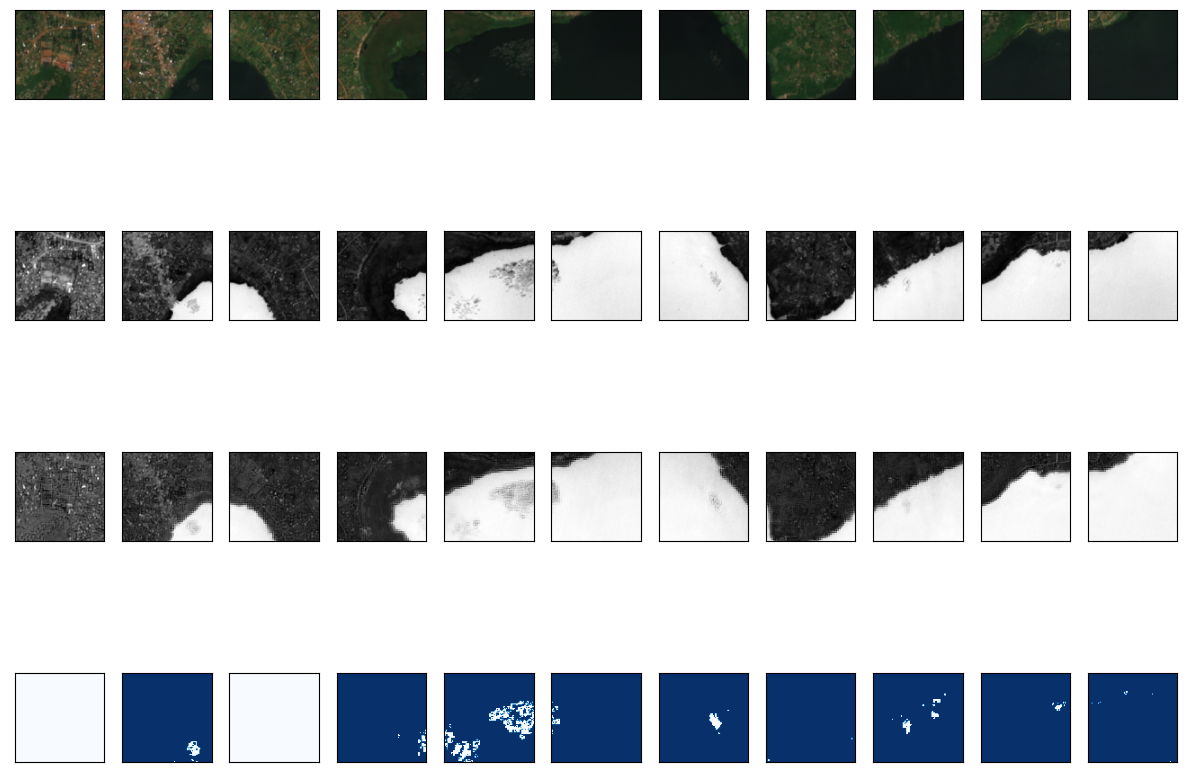

In [8]:
def plot_patch(ax, arr, cmap=None):
    ax.imshow(arr, cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(4, 11, figsize=(15,11))

for i, idx in enumerate([0,1,2,3,4,5,6,7,8,9,10]): #[66, 74, 83, 93, 112, 123]):
    img = list(ds.as_numpy_iterator())[idx]
    rgb = np.concatenate((img['B4'][..., None], img['B3'][..., None], img['B2'][..., None]), axis=2)

    plot_patch(ax[0,i], rgb*3)
    plot_patch(ax[1,i], img['ndwi'], 'Greys_r')
    plot_patch(ax[2,i], img['mndwi'], 'Greys_r')
    plot_patch(ax[3,i], img['classes'], 'Blues')

In [101]:
### Source : https://notebook.community/google/earthengine-api/python/examples/ipynb/UNET_regression_demo
# reproducing the code for our example

In [106]:
# Specify names locations for outputs in Cloud Storage. 
FOLDER = 'lake-victoria'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

# Specify inputs (Sentinel bands) to the model and the response variable.
BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'mndwi', 'ndwi']
RESPONSE = 'classes'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 100
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))
FEATURES_DICT
# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 45
EVAL_SIZE = 45

# Specify model training parameters.
BATCH_SIZE = 16
EPOCHS = 10
BUFFER_SIZE = 2000
OPTIMIZER = 'SGD'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [108]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = [inputs.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

In [110]:
trainPath = Path('/Users/aida/Documents/Modules/Thesis/lake-victoria/data/sentinel2/Sentinel2PatchExport-00000.tfrecord.gz')

train_dataset = tf.data.TFRecordDataset(trainPath, compression_type='GZIP')

# Print the first record to check.
#print(iter(train_dataset).next())
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'mndwi', 'ndwi']
N_CLASSES = 1
image_columns = [
  tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32) 
  for k in bands]

bands += ['classes']
image_columns += [tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.int64)]
image_columns
FEATURE_NAMES = list(bands)
FEATURE_NAMES
LABEL ='classes'

columns = [
  tf.io.FixedLenFeature(shape=[100,100], dtype=tf.float32) for k in FEATURE_NAMES
]
columns

# Parsing dictionary.
features_dict = dict(zip(bands, image_columns))
features_dict

def parse_tfrecord(example_proto):
    """The parsing function.

    Read a serialized example into the structure defined by featuresDict.

    Args:
    example_proto: a serialized Example.

    Returns:
    A tuple of the predictors dictionary and the label, cast to an `int32`.
    """
    parsed_features = tf.io.parse_single_example(example_proto, features_dict)
    labels = parsed_features.pop(LABEL)
    return parsed_features, tf.cast(labels, tf.int32)

# Map the function over the dataset.
parsed_dataset = train_dataset.map(parse_tfrecord, num_parallel_calls=5)

# Print the first parsed record to check.
print(iter(parsed_dataset).next())

({'B1': <tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[0.03465, 0.03465, 0.0376 , ..., 0.0385 , 0.05645, 0.05645],
       [0.03465, 0.03465, 0.0376 , ..., 0.0385 , 0.05645, 0.05645],
       [0.03465, 0.03465, 0.0376 , ..., 0.0385 , 0.05645, 0.05645],
       ...,
       [0.04325, 0.04325, 0.0505 , ..., 0.0416 , 0.03955, 0.03955],
       [0.04325, 0.04325, 0.0505 , ..., 0.0416 , 0.03955, 0.03955],
       [0.04325, 0.04325, 0.0505 , ..., 0.0416 , 0.03955, 0.03955]],
      dtype=float32)>, 'B11': <tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[0.2275 , 0.2275 , 0.25285, ..., 0.2494 , 0.27225, 0.27225],
       [0.2275 , 0.2275 , 0.25285, ..., 0.2494 , 0.27225, 0.27225],
       [0.2146 , 0.2146 , 0.23865, ..., 0.1978 , 0.2145 , 0.2145 ],
       ...,
       [0.2588 , 0.2588 , 0.2648 , ..., 0.23385, 0.23875, 0.23875],
       [0.2588 , 0.2588 , 0.2648 , ..., 0.23385, 0.23875, 0.23875],
       [0.28055, 0.28055, 0.2662 , ..., 0.26795, 0.28195, 0.28195]],
      dtype=floa

In [100]:
img_list = list(iter(parsed_dataset))
img = img_list[0]
img
# img1 = img_list[1]
# len(img1[1])

# ['ndwi']
# rgb1 = np.concatenate((img1['B4'][..., None], img1['B3'][..., None], img1['B2'][..., None]), axis=2)
# label1 = img1['classes']

# img2 = img_list[4]
# rgb2 = np.concatenate((img1['B4'][..., None], img1['B3'][..., None], img1['B2'][..., None]), axis=2)
# label2 = img2['classes']

# fig, ax = plt.subplots(3, 2, figsize=(13,13))

# for i, idx in enumerate([0,1]): #[66, 74, 83, 93, 112, 123]):
#     print(i,idx)
#     imgList = [img1, img2] 
#     img = imgList[idx]
#     rgb = np.concatenate((img['B4'][..., None], img['B3'][..., None], img['B2'][..., None]), axis=2)
#     print(img['classes'])
#     plot_patch(ax[0,i], rgb*3)
#     plot_patch(ax[1,i], img['ndwi'], 'Greys_r')
#     plot_patch(ax[2,i], img['classes'], 'Blues')

({'B1': <tf.Tensor: shape=(100, 100), dtype=float32, numpy=
  array([[0.03465, 0.03465, 0.0376 , ..., 0.0385 , 0.05645, 0.05645],
         [0.03465, 0.03465, 0.0376 , ..., 0.0385 , 0.05645, 0.05645],
         [0.03465, 0.03465, 0.0376 , ..., 0.0385 , 0.05645, 0.05645],
         ...,
         [0.04325, 0.04325, 0.0505 , ..., 0.0416 , 0.03955, 0.03955],
         [0.04325, 0.04325, 0.0505 , ..., 0.0416 , 0.03955, 0.03955],
         [0.04325, 0.04325, 0.0505 , ..., 0.0416 , 0.03955, 0.03955]],
        dtype=float32)>,
  'B11': <tf.Tensor: shape=(100, 100), dtype=float32, numpy=
  array([[0.2275 , 0.2275 , 0.25285, ..., 0.2494 , 0.27225, 0.27225],
         [0.2275 , 0.2275 , 0.25285, ..., 0.2494 , 0.27225, 0.27225],
         [0.2146 , 0.2146 , 0.23865, ..., 0.1978 , 0.2145 , 0.2145 ],
         ...,
         [0.2588 , 0.2588 , 0.2648 , ..., 0.23385, 0.23875, 0.23875],
         [0.2588 , 0.2588 , 0.2648 , ..., 0.23385, 0.23875, 0.23875],
         [0.28055, 0.28055, 0.2662 , ..., 0.26795, 0.28

In [91]:
def to_tuple(inputs, label):
    return (tf.transpose(list(inputs.values())),
          tf.one_hot(indices=label, depth=N_CLASSES))

# Map the to_tuple function, shuffle and batch.
input_dataset = parsed_dataset.map(to_tuple).batch(8)
input_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 2), dtype=tf.float32, name=None))>

In [113]:
# Define the layers in the model.
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(N_CLASSES, activation=tf.nn.softmax)
])

# Compile the model with the specified loss function.
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to the training data.
model.fit(x=input_dataset, epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0117 - accuracy: 0.4645
Epoch 2/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0117 - accuracy: 0.4722
Epoch 3/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0117 - accuracy: 0.4866
Epoch 4/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0117 - accuracy: 0.4994
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0117 - accuracy: 0.5050
Epoch 6/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0117 - accuracy: 0.5073
Epoch 7/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0117 - accuracy: 0.5071
Epoch 8/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0116 - accuracy: 0.5029
Epoch 9/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0117 - accuracy: 0.4957
Epoch 10/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0116 - accuracy: 0.4898
Epoch 11/100
6/6 [=